In [13]:
import os
import sys

import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors
from hydra import initialize, compose
import pickle
from glob import glob
from pprint import pprint
from tqdm import tqdm
import galsim
from copy import deepcopy
import random
from scipy.stats import chi2

# set paths to various directories based on the machine this code is being executed on
try:
    with initialize(version_base=None, config_path='config'):  
        config = compose(config_name='config.yaml')  # overrides=['machine=uzay']
except:
    with initialize(version_base=None, config_path='../../config'):  
        config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir  = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.lenses.test import SampleStrongLens
from mejiro.plots import diagnostic_plot, plot, plot_util, overplot
from mejiro.analysis import stats
from mejiro.utils import util
from mejiro.helpers import gs
from mejiro.lenses import lens_util

from mejiro.instruments.roman import Roman
from mejiro.synthetic_image import SyntheticImage
from mejiro.exposure import Exposure
from mejiro.engines import webbpsf_engine

In [2]:
pipeline_params = util.hydra_to_dict(config.pipeline)
debugging = pipeline_params['debugging']
# debugging = True  # TODO TEMP

if debugging:
    pipeline_dir = f'{config.machine.pipeline_dir}_dev'
else:
    pipeline_dir = config.machine.pipeline_dir

detectable_lenses = lens_util.get_detectable_lenses(pipeline_dir, with_subhalos=False, verbose=True)

  0%|          | 0/18 [00:00<?, ?it/s]

100%|██████████| 18/18 [00:14<00:00,  1.28it/s]


In [24]:
lens = random.choice(detectable_lenses)
print(lens.uid)

00009101


In [25]:
roman = Roman()

sca = 1
sca_position = (2048, 2048)
band = 'F129'
oversample = 5
scene_size = 5
psf_cache_dir = f'{config.machine.data_dir}/cached_psfs'
rng = galsim.UniformDeviate(42)
exposure_time = 146
snr_quantile = 0.95

instrument_params = {
    'detector': sca,
    'detector_position': sca_position
}
kwargs_numerics = {
    'supersampling_factor': 3,
    'compute_mode': 'adaptive',
}

psf_id = webbpsf_engine.get_psf_id(band, sca, sca_position, oversample, 101)
psf = webbpsf_engine.get_cached_psf(psf_id, psf_cache_dir, verbose=False)

Computing on pixel grid of size 235x235 (5.17"x5.17") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)
Computing with kwargs_numerics: {'supersampling_factor': 3, 'compute_mode': 'adaptive', 'supersampled_indexes': array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])}


Initialized SyntheticImage for StrongLens 00009101 by Roman in F129 band
Exposure calculation time with galsim engine: 0:00:00


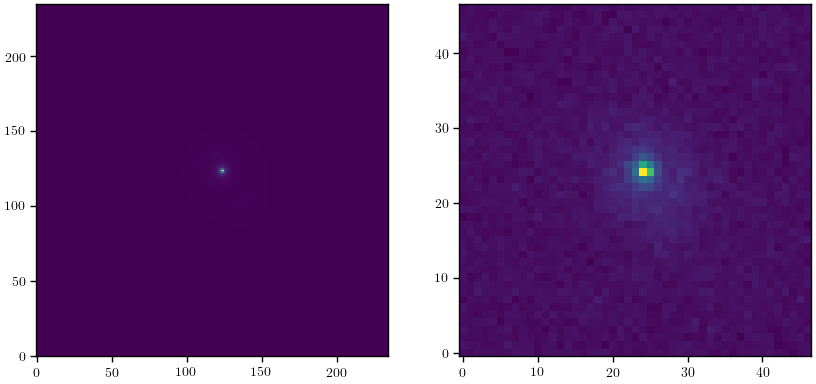

In [26]:
# get image with no subhalos
lens_no_subhalos = deepcopy(lens)
synth_no_subhalos = SyntheticImage(lens_no_subhalos,
                                    roman,
                                    band=band,
                                    arcsec=scene_size,
                                    oversample=oversample,
                                    kwargs_numerics=kwargs_numerics,
                                    instrument_params=instrument_params,
                                    pieces=True,
                                    verbose=True)

engine_params = {
    'rng': rng,
    'reciprocity_failure': False,
    'nonlinearity': False,
    'ipc': False
}
exposure_no_subhalos = Exposure(synth_no_subhalos,
                                exposure_time=exposure_time,
                                engine_params=engine_params,
                                psf=psf,
                                verbose=True)

_, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(synth_no_subhalos.image)
ax[1].imshow(exposure_no_subhalos.exposure)
plt.show()

In [27]:
source_exposure = exposure_no_subhalos.source_exposure

# get noise
poisson_noise = exposure_no_subhalos.poisson_noise
# reciprocity_failure = exposure_no_subhalo.reciprocity_failure
dark_noise = exposure_no_subhalos.dark_noise
# nonlinearity = exposure_no_subhalo.nonlinearity
# ipc = exposure_no_subhalo.ipc
read_noise = exposure_no_subhalos.read_noise

# calculate SNR in each pixel
snr_array = np.nan_to_num(source_exposure / np.sqrt(exposure_no_subhalos.exposure))

# build SNR mask
snr_threshold = np.quantile(snr_array, snr_quantile)
masked_snr_array = np.ma.masked_where(snr_array <= snr_threshold, snr_array)
# masked_snr_array = util.center_crop_image(lens.masked_snr_array, snr_array.shape)
mask = np.ma.getmask(masked_snr_array)
masked_exposure_no_subhalos = np.ma.masked_array(exposure_no_subhalos.exposure, mask=mask)

Computing on pixel grid of size 235x235 (5.17"x5.17") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)
Computing with kwargs_numerics: {'supersampling_factor': 3, 'compute_mode': 'adaptive', 'supersampled_indexes': array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])}
Initialized SyntheticImage for StrongLens 00009101 by Roman in F129 band
Exposure calculation time with galsim engine: 0:00:00


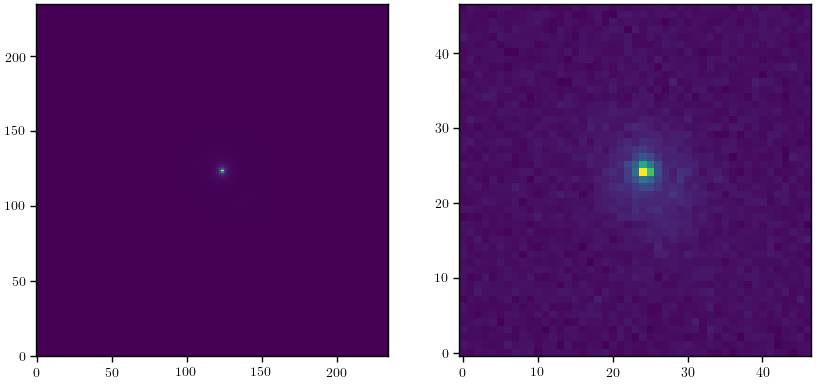

In [28]:
# get image with subhalos
lens_with_subhalos = deepcopy(lens)
realization = lens_with_subhalos.generate_cdm_subhalos()
lens_with_subhalos.add_subhalos(realization)

synth = SyntheticImage(lens_with_subhalos,
                        roman,
                        band=band,
                        arcsec=scene_size,
                        oversample=oversample,
                        kwargs_numerics=kwargs_numerics,
                        instrument_params=instrument_params,
                        verbose=True)

engine_params = {
    'rng': rng,
    'poisson_noise': poisson_noise,
    'reciprocity_failure': False,
    'dark_noise': dark_noise,
    'nonlinearity': False,
    'ipc': False,
    'read_noise': read_noise
}
exposure = Exposure(synth,
                    exposure_time=exposure_time,
                    engine_params=engine_params,
                    check_cache=True,
                    psf=psf,
                    verbose=True)

_, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(synth.image)
ax[1].imshow(exposure.exposure)
plt.show()

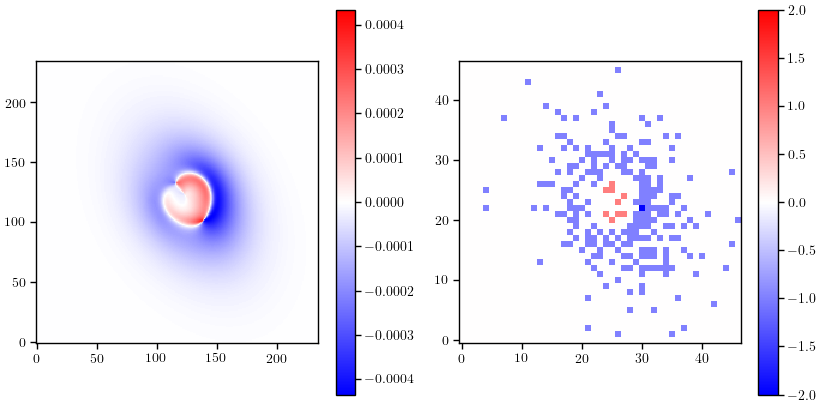

In [29]:
v_synth = plot_util.get_v(synth.image - synth_no_subhalos.image)
v_exposure = plot_util.get_v(exposure.exposure - exposure_no_subhalos.exposure)

_, ax = plt.subplots(1, 2, figsize=(10, 5))
im1 = ax[0].imshow(synth.image - synth_no_subhalos.image, cmap='bwr', vmin=-v_synth, vmax=v_synth)
im2 = ax[1].imshow(exposure.exposure - exposure_no_subhalos.exposure, cmap='bwr', vmin=-v_exposure, vmax=v_exposure)
plt.colorbar(im1, ax=ax[0])
plt.colorbar(im2, ax=ax[1])
plt.show()

In [30]:
# initialize chi2 rv
pixels_unmasked = masked_snr_array.count()
dof = pixels_unmasked - 3
rv = chi2(dof)
threshold_chi2 = rv.isf(0.001)

print({'dof': dof, 'threshold_chi2': threshold_chi2})

{'dof': 108, 'threshold_chi2': 159.1624442888655}


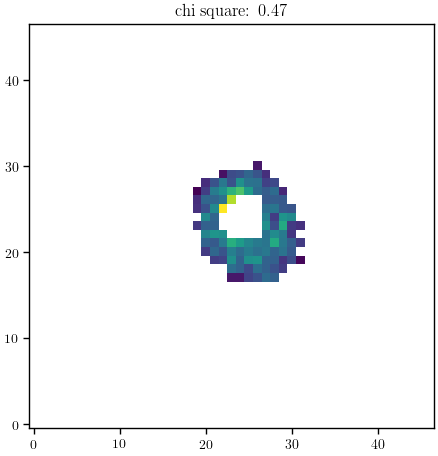

In [31]:
# mask image with subhalo
masked_exposure_with_subhalos = np.ma.masked_array(exposure.exposure, mask=mask)

# calculate chi square
chi_square = stats.chi_square(np.ma.compressed(masked_exposure_with_subhalos),
                                np.ma.compressed(masked_exposure_no_subhalos))

plt.imshow(masked_exposure_with_subhalos)
plt.title(f'chi square: {chi_square:.2f}')
plt.show()